# The main idea

My FOREX trade system and strategy has lots of parameters. Because of the number of parameters, the combinations of the possible test scenarios easily can reach very large numbers. To test all promising scenarios would require a very very and really very long time. For example, if I want to change only six parameters, all of them with 10 different numbers gives 1 million combinations, this means 1 million test runs.

If I want to run tests and trade my strategy in this century I need some techniques to reduce the number of test scenarios :) Here I show how I try to find the best parameter combinations for the tests and how I choose the combinations for trade.

The main idea is to build a sparse grid of parameter combinations in two steps, where the grid is denser in the space where the strategy has a better chance to be in profit. After that, I fit some estimators to this grid where the labels are different metrics of the trade. I use random forest classifiers and regressors because they gave a good fit. Then I build a more dense grid of parameters, where the metrics (for example finished deposit) are estimated by the random forest models. With different metrics, I build a score for each grid. This score is proportional to the chance that the parameter combination (or the grid point) will be selected for trade. Obviously better performing combinations will have a higher score, and losing combinations will have zero scores. From the score with a simple transformation, we get the probability mass function of the grid for selecting the given grid point. I randomly select multiple parameter combinations based on this probabilities and test them on a different year than the tests were run.

My trade system and the strategy:<br>
https://medium.com/@istvan.veber/forex-news-trader-785ad0a1394c<br>
https://medium.com/@istvan.veber/trade-the-news-but-make-your-forex-research-part-2-analysis-and-strategy-e0f2c84a3bdd<br>
https://github.com/sinusgamma/Forex-News-Trader-Dukascopy-API



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 5, 4
import warnings
warnings.simplefilter('ignore')

In [2]:
import os
print(os.listdir("../input"))

['forex-strategy-results-next', 'forex-strategy-results-first']


# EDA of the first test phase

In this kernel I will examine the United States Consumer Price Index Ex Food Energy YoY news events for the USD/JPY pair. I chose this event because it often has high volatility and according to my former examinations the USD/JPY is the best for high-frequency news trading. (At least for USD related news with my strategy.)

I have two test phases. First I run my tests changing only the most important parameters. This is a manual selection based on some statistics of the historical volatility of the news event. In my strategy the single most important parameter is the pointsAway, this determines how far from the zero-time-price I open my pending orders (you can read more about the strategy in the earlier articles, here I focus on the test results and parameter selection). I vary some other important parameters as well. In the dataframe I keep the finishDep (finished deposite) metric as well (from now on I call every number metric which are results of the trade and aren't predefined parameters.). I will use this metrics and others to find the best combinations for phase 2 tests.

I run phase 1 and phase 2 tests on 2014-2016 data, then I select the parameter combinations for trade, and I will show how they perform on 2017 data. 

We can imagine the parameters as a multi-dimensional space, and the goal is to find the part of this space where the strategy perfoms well. 

In [3]:
df_full = pd.read_csv("../input/forex-strategy-results-first/kaggle_USD_United_States_Consumer_Price_Index_Ex_Food__Energy_YoY_USDJPY.csv")
df_full.columns

Index(['closeOnShutDown', 'isTest', 'isMultiScenarioRun', 'eventName',
       'currencyOfEvent', 'testInstrument', 'enabledOrderDirection',
       'pointsAway', 'takeProfit', 'stopLoss', 'modifyGap',
       'secondsBeforePending', 'secondsBeforeModify', 'secondsAfterNews',
       'secondsAfterNewsOffset', 'breakevenTrigger', 'breakevenDistance',
       'trailingStop', 'trailingAfter', 'trailImmediately', 'isOCO',
       'manageMoney', 'calcAmountWithMaxSpread', 'riskPercent', 'amount',
       'maxSpread', 'maxSlippage', 'initDep', 'finishDep', 'commission',
       'turnOver', 'eventPeriodsNbr', 'closedOrderNb', 'buyOrders',
       'sellOrders', 'maxProfit', 'maxLoss', 'profitNb', 'lossNb',
       'profitNbWithComm', 'lossNbWithComm', 'orderPercent', 'profitPercent',
       'profitPercentWithComm', 'avrPLperevent', 'avrPLclosedorder',
       'sumProfit', 'sumLoss', 'sumProfitCom', 'sumLossCom', 'PLrate',
       'PLrateCom'],
      dtype='object')

First I examine only the parameters which are changing during phase 1 tests.

In [4]:
df = df_full[['enabledOrderDirection', 'pointsAway', 'stopLoss', 'trailingStop', 'maxSlippage', 'finishDep']].copy()
df.sort_values(by='finishDep', ascending=False).head()

,enabledOrderDirection,pointsAway,stopLoss,trailingStop,maxSlippage,finishDep
0,LONG,3.4,2.0,9.6,50,1379.97
1,LONG,3.4,2.0,12.5,50,1301.45
2,LONG,3.4,2.0,16.3,50,1253.29
3,LONG,3.4,2.0,3.4,50,1238.78
4,LONG,16.3,2.0,9.6,5,1227.68


In [5]:
df.loc[df['enabledOrderDirection'] == 'LONG', 'enabledOrderDirection'] = 1
df.loc[df['enabledOrderDirection'] == 'SHORT', 'enabledOrderDirection'] = -1
df.head()

,enabledOrderDirection,pointsAway,stopLoss,trailingStop,maxSlippage,finishDep
0,1,3.4,2.0,9.6,50,1379.97
1,1,3.4,2.0,12.5,50,1301.45
2,1,3.4,2.0,16.3,50,1253.29
3,1,3.4,2.0,3.4,50,1238.78
4,1,16.3,2.0,9.6,5,1227.68


In [6]:
print(df.shape)
print(df.info())

(1440, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 6 columns):
enabledOrderDirection    1440 non-null int64
pointsAway               1440 non-null float64
stopLoss                 1440 non-null float64
trailingStop             1440 non-null float64
maxSlippage              1440 non-null int64
finishDep                1440 non-null float64
dtypes: float64(4), int64(2)
memory usage: 67.6 KB
None


In [7]:
df.describe()

,enabledOrderDirection,pointsAway,stopLoss,trailingStop,maxSlippage,finishDep
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,-0.002778,9.550000,6.288750,6.545625,27.343750,955.157347
std,1.000344,8.087207,4.488373,4.679706,22.507274,121.510816
min,-1.000000,1.500000,2.000000,1.500000,5.000000,0.000000
25%,-1.000000,3.200000,2.000000,2.600000,5.000000,939.262500
50%,-1.000000,6.550000,4.400000,4.400000,5.000000,984.165000
75%,1.000000,13.450000,12.500000,9.600000,50.000000,1000.000000
max,1.000000,28.000000,12.500000,16.300000,50.000000,1379.970000


During test, our starting deposit is 1000 USD, so if our finishDep is larger than 1000 USD we have profit.
The first test parameters were chosen well, and the United States Consumer Price Index Ex Food Energy YoY event seems promissing, 23 percent of our combinations resulted in profit.

In [8]:
df.loc[df['finishDep'] > 1000, 'finishDep'].count() / df.shape[0]

0.23125

In [9]:
df.loc[df['finishDep'] < 1000, 'finishDep'].count() / df.shape[0]

0.6854166666666667

In [10]:
df.loc[df['finishDep'] == 1000, 'finishDep'].count() / df.shape[0]

0.08333333333333333

We add a new column to the database for later examinations: 'isInProfit'. I made some ML model to evaluate the 'finisDep' based on the parameters, but they don't contain enough information and weren't so good. But the binary classification of the isInProfit parameter was far better. We will use both later. 

In [11]:
df['isInProfit'] = df['finishDep'].map(lambda x: (x > 1000))
df.head()

,enabledOrderDirection,pointsAway,stopLoss,trailingStop,maxSlippage,finishDep,isInProfit
0,1,3.4,2.0,9.6,50,1379.97,True
1,1,3.4,2.0,12.5,50,1301.45,True
2,1,3.4,2.0,16.3,50,1253.29,True
3,1,3.4,2.0,3.4,50,1238.78,True
4,1,16.3,2.0,9.6,5,1227.68,True


The LONG(1) and SHORT(-1) positions don't have an equal chance to be in profit. Only checking this cross table I should avoid all SHORT trading for this news event, but for some intuition, I will examine both sides a bit more.

In [12]:
pd.crosstab(df['enabledOrderDirection'], df['isInProfit'], margins=True)

isInProfit,False,True,All
enabledOrderDirection,,,
-1,641,81,722
1,466,252,718
All,1107,333,1440


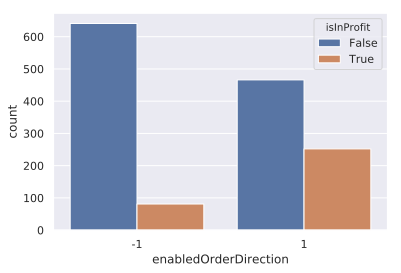

In [13]:
sns.countplot(x='enabledOrderDirection', hue='isInProfit', data=df);

The histograms say the same story, don't trade SHORT.

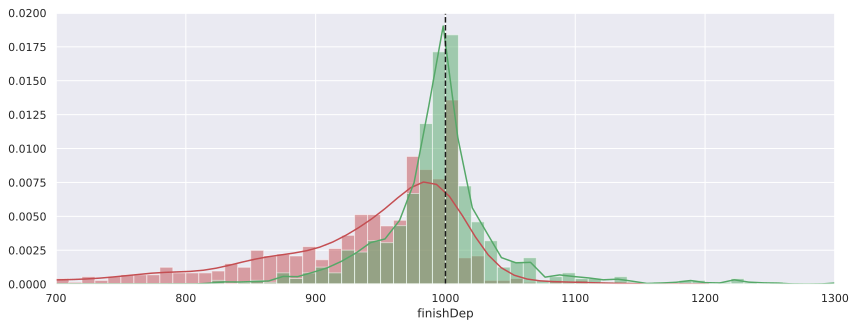

In [14]:
fig, ax = plt.subplots(figsize=(14,5))
sns.distplot(df[df['enabledOrderDirection']==-1]['finishDep'], ax=ax, color='r', bins=range(0, 1500, 10), hist_kws=dict(alpha=0.5))
sns.distplot(df[df['enabledOrderDirection']==1]['finishDep'], ax=ax, color='g', bins=range(0, 1500, 10), hist_kws=dict(alpha=0.5))
ax.axvline(1000, color='k', linestyle='--')
ax.set_xlim(700, 1300);

During test pointsAway and trailingStop had the best "resolution", this is the pointsAway/trailingStop grid.

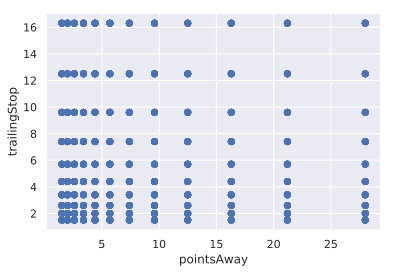

In [15]:
plt.scatter(df['pointsAway'], df['trailingStop'])
plt.xlabel('pointsAway')
plt.ylabel('trailingStop');

The heatmaps below show how the pointsAway/trailingStop combinations performed during phase 1 tests. The first column is the SHORT position, the second is the LONG position. First, we can see the average finishDep, later the average isInProfit. A large part of the LONG combinations has potential and worth to further test that area.

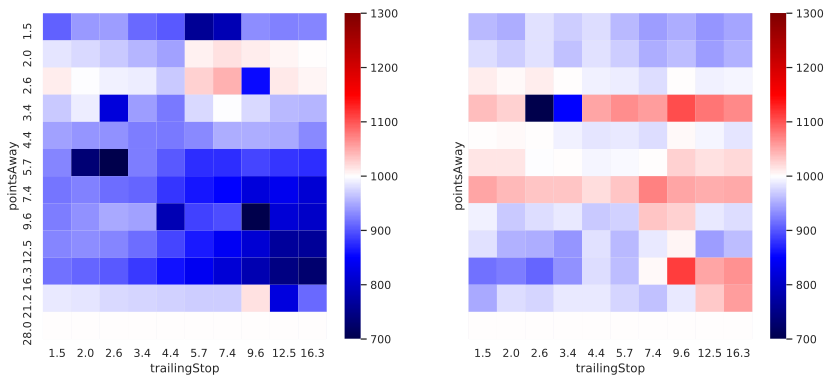

In [16]:
heatmapShort_data = pd.pivot_table(df[df['enabledOrderDirection']==-1], values='finishDep', 
                     index=['pointsAway'], 
                     columns='trailingStop')
heatmapLong_data = pd.pivot_table(df[df['enabledOrderDirection']==1], values='finishDep', 
                     index=['pointsAway'], 
                     columns='trailingStop')
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,6))
sns.heatmap(heatmapShort_data, ax=ax1, vmin=700, vmax=1300, cmap="seismic")
sns.heatmap(heatmapLong_data, ax=ax2, vmin=700, vmax=1300, cmap="seismic")

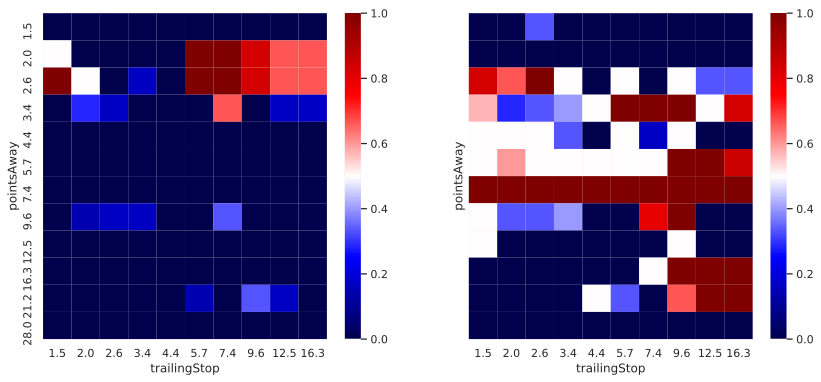

In [17]:
heatmapShort_data = pd.pivot_table(df[df['enabledOrderDirection']==-1], values='isInProfit', 
                     index=['pointsAway'], 
                     columns='trailingStop')
heatmapLong_data = pd.pivot_table(df[df['enabledOrderDirection']==1], values='isInProfit', 
                     index=['pointsAway'], 
                     columns='trailingStop')
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,6))
sns.heatmap(heatmapShort_data, ax=ax1, cmap="seismic")
sns.heatmap(heatmapLong_data, ax=ax2, cmap="seismic")

Checking the maxSlippage shows that the larger maximum slippage is better. During test I use only 5 and 50 pips as maxSlippage. 50 is so large that this practically means that I shouldn't care about maximum slippage.

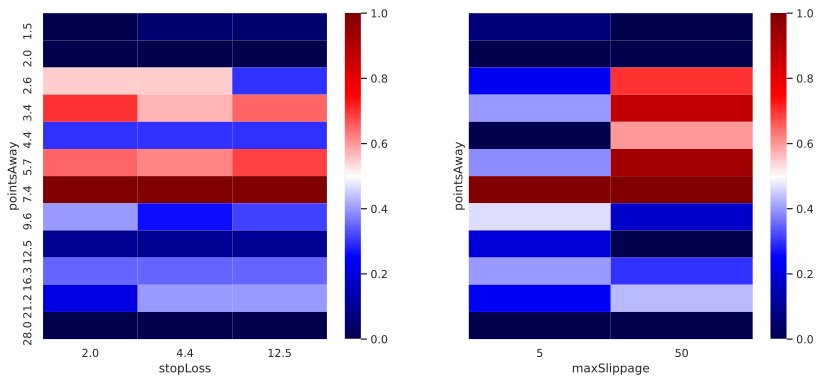

In [18]:
heatmapSL_data = pd.pivot_table(df[df['enabledOrderDirection']==1], values='isInProfit', 
                     index=['pointsAway'], 
                     columns='stopLoss')
heatmapMS_data = pd.pivot_table(df[df['enabledOrderDirection']==1], values='isInProfit', 
                     index=['pointsAway'], 
                     columns='maxSlippage')
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,6))
sns.heatmap(heatmapSL_data, ax=ax1, cmap="seismic")
sns.heatmap(heatmapMS_data, ax=ax2, cmap="seismic")

Swarm plots are great for visualization and notice interesting behaviors. Here the most interesting is the stopLoss plot. Smaller stopLoss results in higher profit or higher loss, while larger stopLoss trades are closer to the starting deposit. The explanation can be that with smaller stopLoss you are earlier stopped out if your filled position is on the wrong side of the main move, but you can be stopped out too early as well.

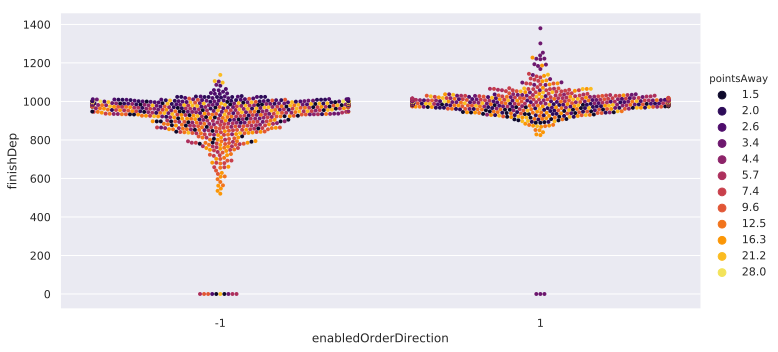

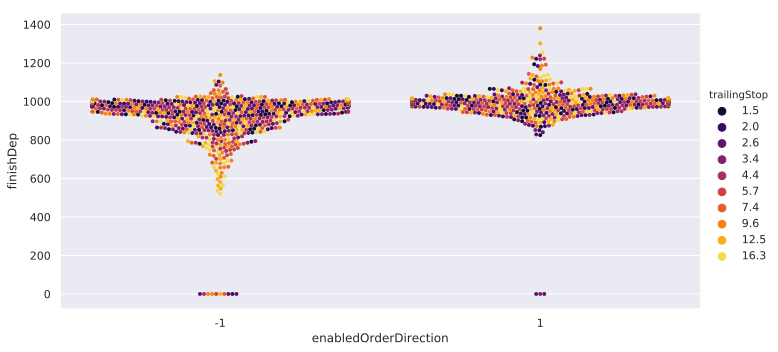

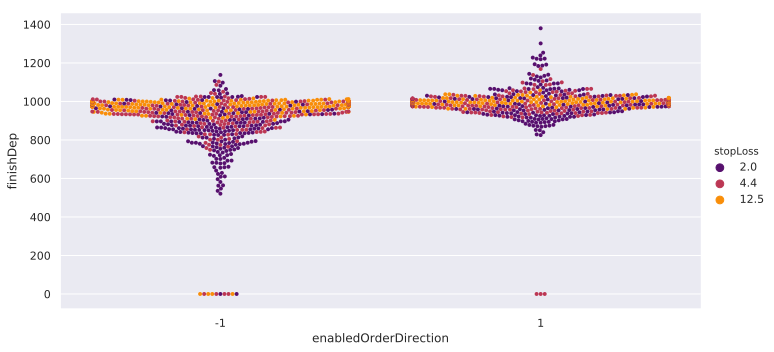

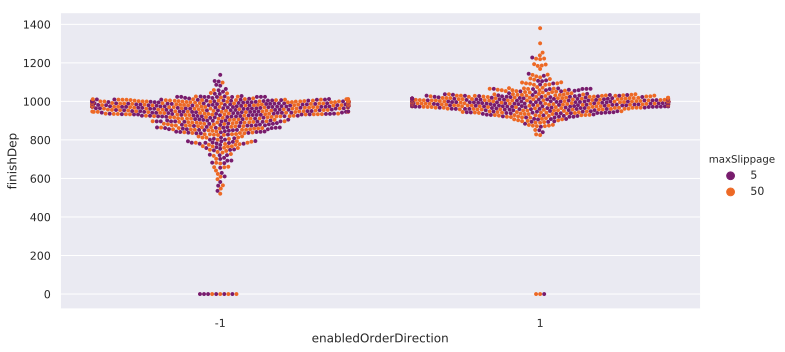

In [19]:
swarms = ['pointsAway', 'trailingStop', 'stopLoss', 'maxSlippage']
for hue in swarms:
    sns.catplot(x="enabledOrderDirection", y="finishDep", hue=hue, data=df, 
            size=5, aspect=2, palette="inferno", s=4, kind='swarm')


In [20]:
df_long = df.loc[df['enabledOrderDirection'] == 1]
print(df_long.shape)
df_long.head()

(718, 7)


,enabledOrderDirection,pointsAway,stopLoss,trailingStop,maxSlippage,finishDep,isInProfit
0,1,3.4,2.0,9.6,50,1379.97,True
1,1,3.4,2.0,12.5,50,1301.45,True
2,1,3.4,2.0,16.3,50,1253.29,True
3,1,3.4,2.0,3.4,50,1238.78,True
4,1,16.3,2.0,9.6,5,1227.68,True


# EDA of the second test phase

After the above examinations, I run a new test without the SHORT positions and only one maxSlippage parameter, but I added new parameters: breakEvenTrigger and breakEvenDistance. Here I load the results of the first test run combined with the second test run.

In [21]:
df_full = pd.read_csv("../input/forex-strategy-results-next/kaggleB_USD_United_States_Consumer_Price_Index_Ex_Food__Energy_YoY_USDJPY.csv")
df_full.columns

Index(['closeOnShutDown', 'isTest', 'isMultiScenarioRun', 'eventName',
       'currencyOfEvent', 'testInstrument', 'enabledOrderDirection',
       'pointsAway', 'takeProfit', 'stopLoss', 'modifyGap',
       'secondsBeforePending', 'secondsBeforeModify', 'secondsAfterNews',
       'secondsAfterNewsOffset', 'breakevenTrigger', 'breakevenDistance',
       'trailingStop', 'trailingAfter', 'trailImmediately', 'isOCO',
       'manageMoney', 'calcAmountWithMaxSpread', 'riskPercent', 'amount',
       'maxSpread', 'maxSlippage', 'initDep', 'finishDep', 'commission',
       'turnOver', 'eventPeriodsNbr', 'closedOrderNb', 'buyOrders',
       'sellOrders', 'maxProfit', 'maxLoss', 'profitNb', 'lossNb',
       'profitNbWithComm', 'lossNbWithComm', 'orderPercent', 'profitPercent',
       'profitPercentWithComm', 'avrPLperevent', 'avrPLclosedorder',
       'sumProfit', 'sumLoss', 'sumProfitCom', 'sumLossCom', 'PLrate',
       'PLrateCom'],
      dtype='object')

I drop the SHORT positions of the first test run.

In [22]:
df_full = df_full.loc[df_full['enabledOrderDirection'] =='LONG']
df_full.shape

(2942, 52)

For selecting the parameter combinations of the trade I will use different metrics, not only the finishDep.

In [23]:
df = df_full[['pointsAway', 'stopLoss', 'trailingStop', 'breakevenTrigger', 'breakevenDistance', 'maxSlippage', 'finishDep', 'profitNb', 'orderPercent', 'profitPercent', 'avrPLclosedorder', 'PLrateCom', 'profitNbWithComm']].copy()
df['isInProfit'] = df['finishDep'].map(lambda x: (x > 1000))
df.sort_values(by='finishDep', ascending=False).head()

,pointsAway,stopLoss,trailingStop,breakevenTrigger,breakevenDistance,maxSlippage,finishDep,profitNb,orderPercent,profitPercent,avrPLclosedorder,PLrateCom,profitNbWithComm,isInProfit
0,3.4,2.0,9.6,12.5,9.6,50,1402.21,7,0.25,0.777778,44.690000,5.052583862,7,True
6,3.4,2.0,9.6,4.4,4.4,50,1379.97,7,0.25,0.777778,42.218889,4.890276356,7,True
9,3.4,2.0,9.6,12.5,4.4,50,1379.97,7,0.25,0.777778,42.218889,4.890276356,7,True
8,3.4,2.0,9.6,12.5,2.0,50,1379.97,7,0.25,0.777778,42.218889,4.890276356,7,True
7,3.4,2.0,9.6,12.5,0.0,50,1379.97,7,0.25,0.777778,42.218889,4.890276356,7,True


The pointsAway alone doesn't show noticable linear association with the finishDep.

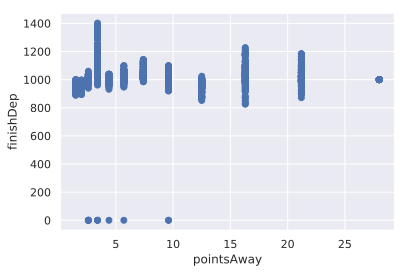

In [24]:
plt.scatter(df['pointsAway'], df['finishDep'])
plt.xlabel('pointsAway')
plt.ylabel('finishDep');

Let's see some projections with our new parameters. The breakEvenTrigger 0 means no break even mechanism, and no break even seems worse than any break even triggers distance.

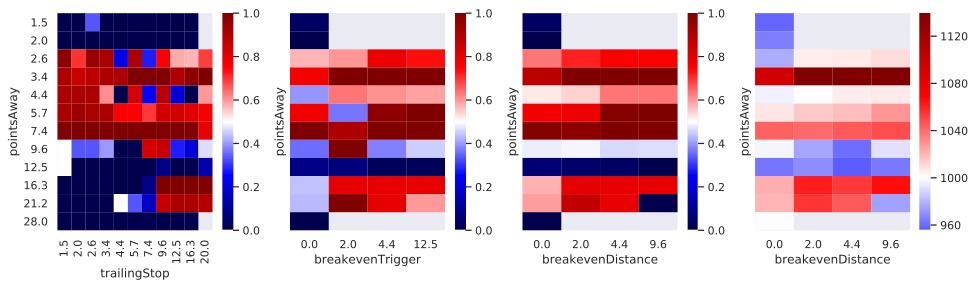

In [25]:
heatmapTS_data = pd.pivot_table(df, values='isInProfit', 
                     index=['pointsAway'], 
                     columns='trailingStop')
heatmapBT_data = pd.pivot_table(df, values='isInProfit', 
                     index=['pointsAway'], 
                     columns='breakevenTrigger')
heatmapBD_data = pd.pivot_table(df, values='isInProfit', 
                     index=['pointsAway'], 
                     columns='breakevenDistance')
heatmapFD_data = pd.pivot_table(df, values='finishDep', 
                     index=['pointsAway'], 
                     columns='breakevenDistance')
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(16,4))
sns.heatmap(heatmapTS_data, ax=ax1, cmap="seismic")
sns.heatmap(heatmapBT_data, ax=ax2, cmap="seismic")
sns.heatmap(heatmapBD_data, ax=ax3, cmap="seismic")
sns.heatmap(heatmapFD_data, ax=ax4, cmap="seismic", center=1000)

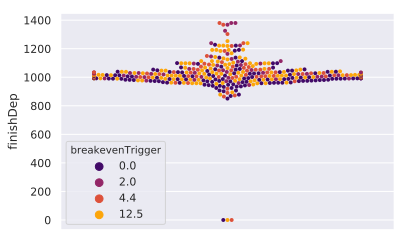

In [26]:
dfs=df.sample(n=500, replace=False, random_state=1)
sns.swarmplot(y=dfs["finishDep"], hue=dfs["breakevenTrigger"], x=[""]*len(dfs), size=5, palette="inferno", s=4)

# Fitting random forest models

Now I fit some random forest estimators to different metrics like isInProfit, finishDep and profitPercent.
First fit for isInProfit.

In [27]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [28]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, 
                            class_weight='balanced')
parameters = {'max_features': [2, 4, 6], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5,10,15]}

X = df[['pointsAway', 'stopLoss', 'trailingStop', 'breakevenTrigger', 'breakevenDistance', 'maxSlippage']]
y_IIP = df['isInProfit']

We can see that the pointsAway is the most important feature and trailingStop helped a lot as well, and breakevenTrigger seems a useful parameter.

### Label isInProfit

In [29]:
%%time
rf_IIP = GridSearchCV(rf, parameters, n_jobs=-1, scoring='roc_auc', cv=skf, verbose=True)
rf_IIP = rf_IIP.fit(X, y_IIP)
print(rf_IIP.best_score_)
print(rf_IIP.best_estimator_.feature_importances_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   47.0s finished


0.9888394303292456
[0.5049016  0.0348926  0.25328981 0.12507779 0.02544368 0.05639451]
CPU times: user 1.37 s, sys: 116 ms, total: 1.49 s
Wall time: 47.4 s


In [30]:
df['iip_est'] = rf_IIP.best_estimator_.predict(X)

The best estimator for isInProfit gives us a very similar space compared to the original data.

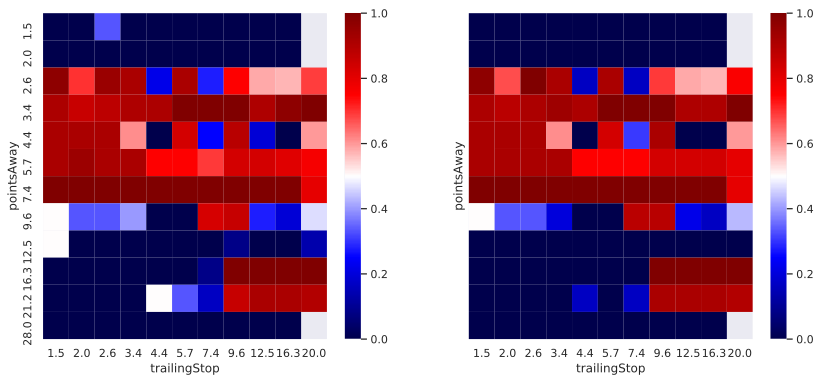

In [31]:
heatmapIIP_data = pd.pivot_table(df, values='isInProfit', 
                     index=['pointsAway'], 
                     columns='trailingStop')
heatmapPRED_data = pd.pivot_table(df, values='iip_est', 
                     index=['pointsAway'], 
                     columns='trailingStop')
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,6))
sns.heatmap(heatmapIIP_data, ax=ax1, cmap="seismic")
sns.heatmap(heatmapPRED_data, ax=ax2, cmap="seismic")

### Label finishDep

After the isInProfit classifier fit random forest regression model for finishDep.

In [32]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics.regression import mean_squared_error

y_FD = df['finishDep']
y_PNC = df['profitNbWithComm']

In [33]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y_FD)
rf_FD = GridSearchCV(RandomForestRegressor(n_jobs=-1, random_state=17), 
                                 parameters, 
                                 scoring='neg_mean_squared_error',  
                                 n_jobs=-1, cv=5,
                                  verbose=True)
rf_FD.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   28.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=17, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': [2, 4, 6], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=True)

In [34]:
rf_FD.best_params_, rf_FD.best_score_

({'max_depth': 15, 'max_features': 4, 'min_samples_leaf': 5},
 -5349.720161977742)

In [35]:
print("Mean squared error (cv): %.3f" % np.mean(np.abs(cross_val_score(rf_FD.best_estimator_,
                                                        X_train, y_train, 
                                                        scoring='neg_mean_squared_error'))))
print("Mean squared error (test): %.3f" % mean_squared_error(y_holdout, 
                                                             rf_FD.predict(X_holdout)))

Mean squared error (cv): 5412.835
Mean squared error (test): 3646.442


In [36]:
rf_FD.best_estimator_.feature_importances_

array([0.54233012, 0.1437419 , 0.16992643, 0.08969031, 0.01530371,
       0.03900753])

In [37]:
df['fd_est'] = rf_FD.best_estimator_.predict(X)

The best estimator for finishDep gives us a very similar space compared to the original data.

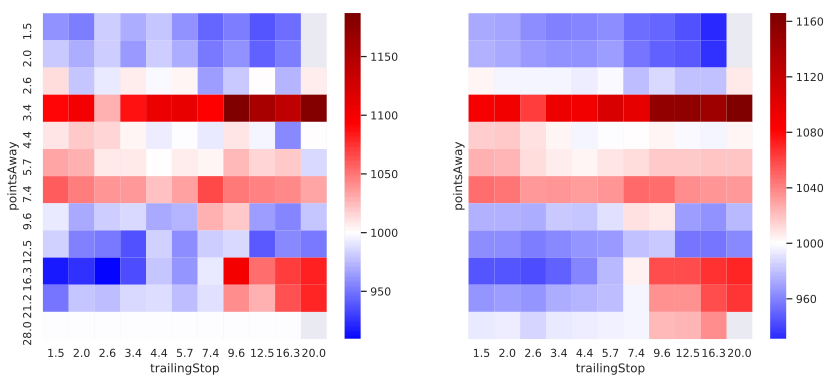

In [38]:
heatmapFD_data = pd.pivot_table(df, values='finishDep', 
                     index=['pointsAway'], 
                     columns='trailingStop')
heatmapPRED_data = pd.pivot_table(df, values='fd_est', 
                     index=['pointsAway'], 
                     columns='trailingStop')
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,6))
sns.heatmap(heatmapFD_data, ax=ax1, cmap="seismic", center=1000)
sns.heatmap(heatmapPRED_data, ax=ax2, cmap="seismic", center=1000)

### Label profitNbWithComm

When selecting our parameter combinations for trading I want to decrease the chance of the combinations which have low probability to be filled, so I fit for profitNbWithComm and later use it for altering the probabilities. profitNbWithComm: number of filled positions in profit after subtracting commission.

In [39]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y_PNC)
rf_PNC = GridSearchCV(RandomForestRegressor(n_jobs=-1, random_state=17), 
                                 parameters, 
                                 scoring='neg_mean_squared_error',  
                                 n_jobs=-1, cv=5,
                                  verbose=True)
rf_PNC.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   28.5s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=17, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_features': [2, 4, 6], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=True)

In [40]:
rf_PNC.best_params_, rf_PNC.best_score_

({'max_depth': 15, 'max_features': 6, 'min_samples_leaf': 3},
 -0.3432130991103797)

In [41]:
rf_PNC.best_estimator_.feature_importances_

array([0.67251655, 0.00949348, 0.1230081 , 0.08057526, 0.02135129,
       0.09305532])

In [42]:
df['pnc_est'] = rf_PNC.best_estimator_.predict(X)

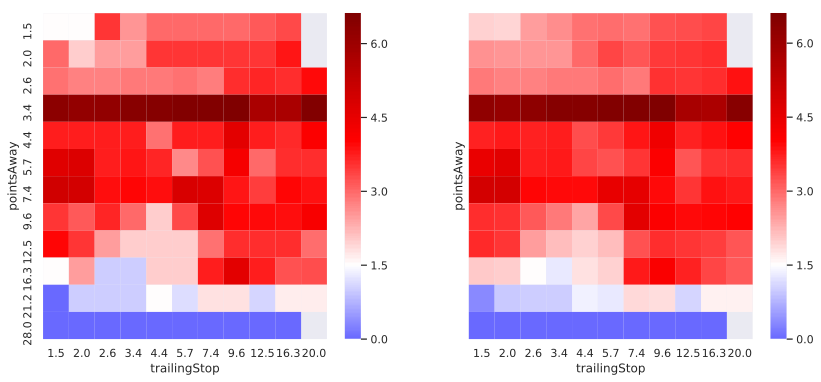

In [43]:
heatmapPNC_data = pd.pivot_table(df, values='profitNbWithComm', 
                     index=['pointsAway'], 
                     columns='trailingStop')
heatmapPRED_data = pd.pivot_table(df, values='pnc_est', 
                     index=['pointsAway'], 
                     columns='trailingStop')
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14,6))
sns.heatmap(heatmapPNC_data, ax=ax1, cmap="seismic", center=1.5)
sns.heatmap(heatmapPRED_data, ax=ax2, cmap="seismic", center=1.5)

# The dense grid of parameters

I build a grid wich has more grid points than the testgrid.

In [44]:
# check the max and min of the parameters we want vary
X.describe()

,pointsAway,stopLoss,trailingStop,breakevenTrigger,breakevenDistance,maxSlippage
count,2942.000000,2942.000000,2942.000000,2942.000000,2942.000000,2942.000000
mean,7.969273,6.313392,8.549252,5.095683,1.839157,44.478246
std,6.135553,4.507293,5.858270,5.164707,2.728881,14.766966
min,1.500000,2.000000,1.500000,0.000000,0.000000,5.000000
25%,3.400000,2.000000,3.400000,0.000000,0.000000,50.000000
50%,5.700000,4.400000,7.400000,4.400000,0.000000,50.000000
75%,9.600000,12.500000,12.500000,12.500000,2.000000,50.000000
max,28.000000,12.500000,20.000000,12.500000,9.600000,50.000000


In [45]:
# use logspace for better resolution on smaller scales
# don't extrapolate with estimators, so grid is between the minmax of the test parameters
# logspace for better resolution with smaller numbers
# pointsAway is the most important, it determines where I open my pending orders, so it has the best resolution
x0 = np.logspace(np.log10(1.5), np.log10(30), num=50)
# stopLoss
x1 = np.logspace(np.log10(2), np.log10(12.5), num=6)
# trailingStop
x2 = np.logspace(np.log10(1.5), np.log10(20), num=25)
# breakevenTrigger 0.0 means no break even mechanism, and the breakEvenTrigger distances are between 2 and 12,5
x3 = np.concatenate(([0.0], np.logspace(np.log10(2), np.log10(12.5), num=5)), axis=None)
# breakevenDistance 0.0 means set stopLoss to the open price, so normal logspace
x4 = np.concatenate(([0.0], np.logspace(np.log10(0.5), np.log10(9.6), num=5)), axis=None)
# maxSlippage only want to select combinations where maxSlippage is 50 - I need this feature for the grid, because the eastimators were trained with it.
x5 = [50.0]

In [46]:
# build grid
x0v, x1v, x2v, x3v, x4v, x5v = np.meshgrid(x0, x1, x2, x3, x4, x5, sparse=False)

In [47]:
X_grid = np.array([x0v, x1v, x2v, x3v, x4v, x5v]).reshape(6, -1).T
X_grid.shape

(270000, 6)

The new df_grid dataframe will contain the grid values and the estimated metrics of the grid.

In [48]:
df_grid = pd.DataFrame(X_grid, columns=['pointsAway', 'stopLoss', 'trailingStop', 'breakevenTrigger', 'breakevenDistance', 'maxSlippage'])

# Estimating metrics over the denser grid

In [49]:
df_grid['iip_est'] = rf_IIP.best_estimator_.predict(X_grid)
df_grid['fd_est'] = rf_FD.best_estimator_.predict(X_grid)
df_grid['pnc_est'] = rf_PNC.best_estimator_.predict(X_grid)
df_grid.head()

,pointsAway,stopLoss,trailingStop,breakevenTrigger,breakevenDistance,maxSlippage,iip_est,fd_est,pnc_est
0,1.5,2.0,1.5,0.0,0.000000,50.0,False,955.705666,1.861996
1,1.5,2.0,1.5,0.0,0.500000,50.0,False,955.705666,1.861996
2,1.5,2.0,1.5,0.0,1.046635,50.0,False,957.523833,1.861996
3,1.5,2.0,1.5,0.0,2.190890,50.0,False,957.523833,1.861996
4,1.5,2.0,1.5,0.0,4.586125,50.0,False,957.523833,1.861996


We don't want to trade combinations where the model estimates that it will not be in profit (classifier) or estimates negative profit (finished deposite < 1000), or breakEvenDistance >= breakEvenTrigger. Instead of giving them zero probabilities later we just drop them.

In [50]:
# only profitable trades
df_grid = df_grid.loc[(df_grid['iip_est'] == True)]
# almost same as above, but for the regression values
df_grid = df_grid.loc[(df_grid['fd_est'] > 1000)]
# breakevenDistance and breakevenTrigger are relative to the open price, a large breakevenDistance would kick out the position
df_grid = df_grid.loc[(df_grid['breakevenDistance'] < df_grid['breakevenTrigger'])]
df_grid.shape

(72194, 9)

In [51]:
# new metric of profit relative to the open deposite
df_grid['gainRate'] = (df_grid['fd_est']/1000)-1

# Selecting the parameters for trade

I will select the parameter combinations for trading based on the gainRate, but I want to decrease the chance of the combinations where there were less profitable trades. So I multiply this gainRate with the pnc_est (estimated number of the trades in profit) parameter (the square root of it not to punish rarer combinations too much). 

In [52]:
df_grid['score'] = df_grid['gainRate'] * np.sqrt(df_grid['pnc_est'])

The probability of each parameter combination could be calculated from this score. But here I used gainRate, so the probability of a combination isn't related to the profitNumberComm parameter.

In [53]:
df_grid['prob'] = df_grid['gainRate'] / df_grid['gainRate'].sum()
df_grid.head()

,pointsAway,stopLoss,trailingStop,breakevenTrigger,breakevenDistance,maxSlippage,iip_est,fd_est,pnc_est,gainRate,score,prob
6318,2.301191,2.0,1.5,5.0,0.000000,50.0,True,1026.797860,2.914286,0.026798,0.045747,0.000008
6319,2.301191,2.0,1.5,5.0,0.500000,50.0,True,1026.797860,2.914286,0.026798,0.045747,0.000008
6320,2.301191,2.0,1.5,5.0,1.046635,50.0,True,1027.652132,3.000000,0.027652,0.047895,0.000008
6321,2.301191,2.0,1.5,5.0,2.190890,50.0,True,1027.652132,3.000000,0.027652,0.047895,0.000008
6322,2.301191,2.0,1.5,5.0,4.586125,50.0,True,1027.652132,3.000000,0.027652,0.047895,0.000008


Let's select the parameters for our trade:<br>
(Weights doesn't need real probabilities, it would scale any column, I just wanted to see them.)

In [54]:
df_sample = df_grid.sample(n=100, weights='prob')

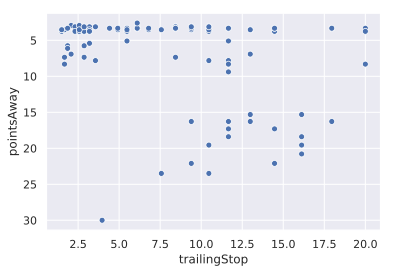

In [55]:
ax = sns.scatterplot(df_sample['trailingStop'], df_sample['pointsAway'])
ax.invert_yaxis()

In [56]:
df_sample.to_csv("trading_sample.csv", index=True)

# Results

The earlier tests to build the grid were run on 2014-2016 data. The randomly sampled parameters were run on 2017 data. There were only 11 United States Consumer Price Index Ex Food Energy YoY events, and examining this event alone isn't enough to show if the strategy works or not. I need more examinations with more events and time-frames. But here I only wanted to show the parameter combination selection process. 

The tests on 2017 data based on the 2014-2016 parameter grid were really well in the case of United States Consumer Price Index Ex Food Energy YoY. The behavior of the tick price was smooth and without jigsaw patterns (most of the time). In the Dukascopy tester the default was 50000 USD, and I forgot to change, and I used the minimum trade amount for the tests. 

date          finished    profit<br>
2017-01-18 13:30___50016.48___16.48<br>
2017-02-15 13:30___50112.27___112.27<br>
2017-03-15 12:30___50022.45___22.45<br>
2017-04-14 12:30___49997.12___-2.88<br>
2017-05-12 12:30___50000___0<br>
2017-06-14 12:30___50000___0<br>
2017-07-14 12:30___50000___0<br>
2017-08-11 12:30___50000___0<br>
2017-09-14 12:30___50116.99___116.99<br>
2017-10-13 12:30___50000___0<br>
2017-11-15 13:30___49965.85___-34.15<br>

<img src="https://raw.githubusercontent.com/sinusgamma/FOREX-strategy-parameter-selection/master/jan.JPG" />
<img src="https://raw.githubusercontent.com/sinusgamma/FOREX-strategy-parameter-selection/master/feb.JPG" />
<img src="https://raw.githubusercontent.com/sinusgamma/FOREX-strategy-parameter-selection/master/mar.JPG" />
<img src="https://raw.githubusercontent.com/sinusgamma/FOREX-strategy-parameter-selection/master/apr.JPG" />
<img src="https://raw.githubusercontent.com/sinusgamma/FOREX-strategy-parameter-selection/master/may.JPG" />
<img src="https://raw.githubusercontent.com/sinusgamma/FOREX-strategy-parameter-selection/master/jun.JPG" />
<img src="https://raw.githubusercontent.com/sinusgamma/FOREX-strategy-parameter-selection/master/jul.JPG" />
<img src="https://raw.githubusercontent.com/sinusgamma/FOREX-strategy-parameter-selection/master/aug.JPG" />
<img src="https://raw.githubusercontent.com/sinusgamma/FOREX-strategy-parameter-selection/master/sep.JPG" />
<img src="https://raw.githubusercontent.com/sinusgamma/FOREX-strategy-parameter-selection/master/okt.JPG" />
<img src="https://raw.githubusercontent.com/sinusgamma/FOREX-strategy-parameter-selection/master/nov.JPG" />

# A better approach

The above system helps a lot but could be better. I run too many tests where the strategy will fail or doesn't even fill orders. The idea is that instead of a grid based system I could use a random parameter selection system. First I would start a test with one parameter combination, and if the test runs I randomly choose another parameter combination. After every tested parameter combination I would calculate a minimum distance for that point in the parameter space. Any new combination should be further from all earlier points than their minimum distances. This distance could be smaller if the parameter combination was in profit, and shouldn't be the same in the different parameter directions, so I need would require some thinking to find a good distance calculation. Maybe later I will try to build it.